In [1]:
# =========================
# 1) Imports + Settings
# =========================
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from scipy.sparse import csr_matrix
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report


In [2]:
# -------------------------
# Config
# -------------------------
DATA_DIR = "./data"  # change if your CSVs are elsewhere

FILES = {
    "orders": "olist_orders_dataset.csv",
    "order_items": "olist_order_items_dataset.csv",
    "products": "olist_products_dataset.csv",
    "customers": "olist_customers_dataset.csv",
    "reviews": "olist_order_reviews_dataset.csv",
    "cat_translation": "product_category_name_translation.csv",
}

DATA_DIR = "./data" sets the folder path where all your CSV dataset files are stored.

FILES is a dictionary that maps a simple label (like "orders" or "products") to the actual CSV filename.

This makes loading files easier and avoids repeating or mistyping filenames throughout the code.


In [3]:
def must_exist(path: str) -> None:
    if not os.path.exists(path):
        raise FileNotFoundError(
            f"Missing file: {path}\n"
            f"Make sure you downloaded + unzipped the dataset into: {DATA_DIR}"
        )

for _, fname in FILES.items():
    must_exist(os.path.join(DATA_DIR, fname))

must_exist(path) checks whether a file exists at the given path.

If the file is missing, it immediately raises a FileNotFoundError with a clear message showing which file is missing and where the dataset should be placed.

The for loop goes through every filename listed in FILES and calls must_exist to verify all required CSVs are present inside DATA_DIR before the program continues.

In [4]:
# =========================
# 2) Load Data
# =========================
orders = pd.read_csv(os.path.join(DATA_DIR, FILES["orders"]))
order_items = pd.read_csv(os.path.join(DATA_DIR, FILES["order_items"]))
products = pd.read_csv(os.path.join(DATA_DIR, FILES["products"]))
customers = pd.read_csv(os.path.join(DATA_DIR, FILES["customers"]))
reviews = pd.read_csv(os.path.join(DATA_DIR, FILES["reviews"]))

This block loads each CSV file into a separate pandas DataFrame using pd.read_csv().

os.path.join(DATA_DIR, FILES["..."]) builds the full file path safely by combining the data folder and the filename.

After this, orders, order_items, products, customers, and reviews each hold one dataset table that you’ll later merge and analyze.

In [5]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [6]:
# Basic cleaning / typing
orders["order_purchase_timestamp"] = pd.to_datetime(orders["order_purchase_timestamp"], errors="coerce")
orders["order_delivered_customer_date"] = pd.to_datetime(orders["order_delivered_customer_date"], errors="coerce")
orders["order_estimated_delivery_date"] = pd.to_datetime(orders["order_estimated_delivery_date"], errors="coerce")

In [7]:
# Merge core tables for EDA
# order_items has product_id + price + freight + quantity proxy (each row = an item line in order)
# orders has timestamps + status
# customers has customer_unique_id (more stable than customer_id)
df = (
    order_items
    .merge(orders[["order_id", "customer_id", "order_status", "order_purchase_timestamp",
                   "order_delivered_customer_date", "order_estimated_delivery_date"]],
           on="order_id", how="left")
    .merge(customers[["customer_id", "customer_unique_id", "customer_state"]], on="customer_id", how="left")
    .merge(products[["product_id", "product_category_name"]], on="product_id", how="left")
)

This merge combines order items, order details, customer information, and product categories into one dataset so each purchased product has who bought it, when it was bought, where it was bought, and what kind of product it is.
Having everything in one table makes EDA and recommendation modeling straightforward and consistent.

In [8]:
df.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_state,product_category_name
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-20 23:43:48,2017-09-29,871766c5855e863f6eccc05f988b23cb,RJ,cool_stuff
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-05-12 16:04:24,2017-05-15,eb28e67c4c0b83846050ddfb8a35d051,SP,pet_shop
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-22 13:19:16,2018-02-05,3818d81c6709e39d06b2738a8d3a2474,MG,moveis_decoracao
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-14 13:32:39,2018-08-20,af861d436cfc08b2c2ddefd0ba074622,SP,perfumaria
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-03-01 16:42:31,2017-03-17,64b576fb70d441e8f1b2d7d446e483c5,SP,ferramentas_jardim


In [9]:
# Add reviews
df = df.merge(reviews[["order_id", "review_score", "review_comment_message"]], on="order_id", how="left")

In [10]:
df.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_state,product_category_name,review_score,review_comment_message
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-20 23:43:48,2017-09-29,871766c5855e863f6eccc05f988b23cb,RJ,cool_stuff,5.0,"Perfeito, produto entregue antes do combinado."
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-05-12 16:04:24,2017-05-15,eb28e67c4c0b83846050ddfb8a35d051,SP,pet_shop,4.0,NaN
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-22 13:19:16,2018-02-05,3818d81c6709e39d06b2738a8d3a2474,MG,moveis_decoracao,5.0,Chegou antes do prazo previsto e o produto sur...
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-14 13:32:39,2018-08-20,af861d436cfc08b2c2ddefd0ba074622,SP,perfumaria,4.0,NaN
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-03-01 16:42:31,2017-03-17,64b576fb70d441e8f1b2d7d446e483c5,SP,ferramentas_jardim,5.0,Gostei pois veio no prazo determinado .


In [11]:
# =========================
# 3) Quick Data Health Checks
# =========================
print("Rows:", len(df))
print("Unique orders:", df["order_id"].nunique())
print("Unique customers:", df["customer_unique_id"].nunique())
print("Unique products:", df["product_id"].nunique())
print("\nMissing % (top 10 columns):")
print((df.isna().mean().sort_values(ascending=False).head(10) * 100).round(2))

Rows: 113314
Unique orders: 98666
Unique customers: 95420
Unique products: 32951

Missing % (top 10 columns):
review_comment_message           57.96
order_delivered_customer_date     2.18
product_category_name             1.42
review_score                      0.83
order_id                          0.00
order_item_id                     0.00
product_id                        0.00
seller_id                         0.00
shipping_limit_date               0.00
order_status                      0.00
dtype: float64


In [12]:
# Keep only delivered orders for cleaner recommendation training
df_delivered = df[df["order_status"] == "delivered"].copy()
df_delivered = df_delivered.dropna(subset=["order_purchase_timestamp", "customer_unique_id", "product_id"])

print("\nDelivered rows:", len(df_delivered))
print("Delivered unique orders:", df_delivered["order_id"].nunique())


Delivered rows: 110840
Delivered unique orders: 96478


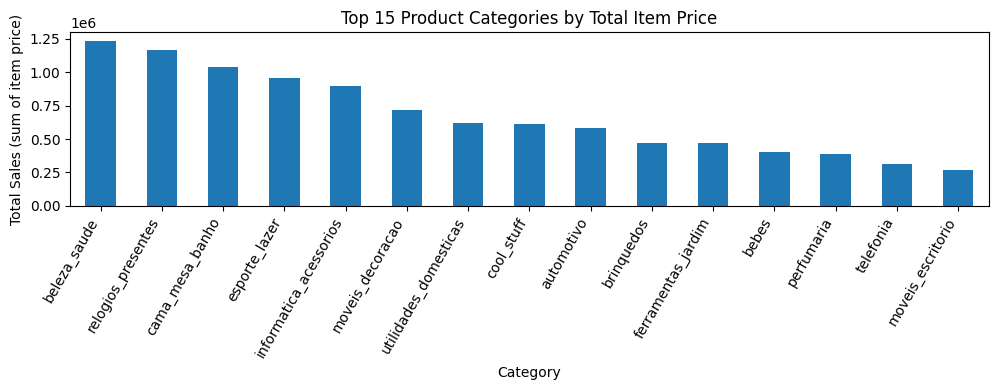

In [13]:
# =========================
# 4) EDA (Business-driven)
# =========================

# ---- 4.1 Top product categories by sales value ----
cat_sales = (
    df_delivered.groupby("product_category_name")["price"]
    .sum()
    .sort_values(ascending=False)
    .head(15)
)

plt.figure(figsize=(10, 4))
cat_sales.plot(kind="bar")
plt.title("Top 15 Product Categories by Total Item Price")
plt.ylabel("Total Sales (sum of item price)")
plt.xlabel("Category")
plt.xticks(rotation=60, ha="right")
plt.tight_layout()
plt.show()

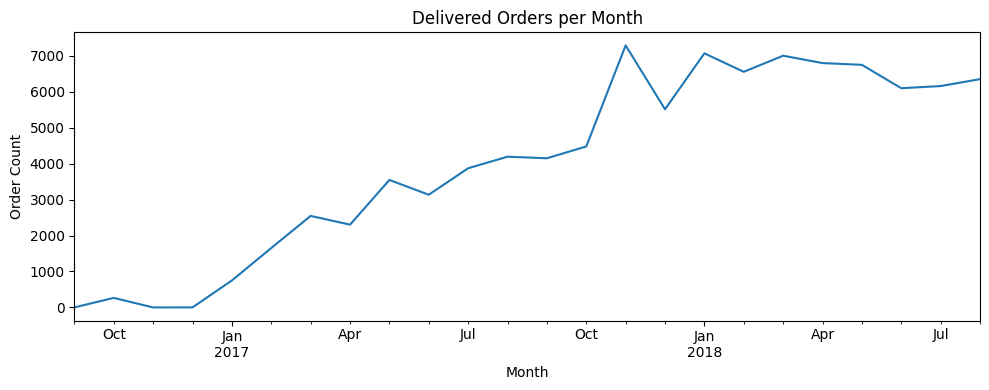

In [14]:
# ---- 4.2 Seasonality: orders per month ----
orders_monthly = (
    df_delivered.drop_duplicates("order_id")
    .set_index("order_purchase_timestamp")
    .resample("MS")["order_id"].count()
)

plt.figure(figsize=(10, 4))
orders_monthly.plot()
plt.title("Delivered Orders per Month")
plt.ylabel("Order Count")
plt.xlabel("Month")
plt.tight_layout()
plt.show()

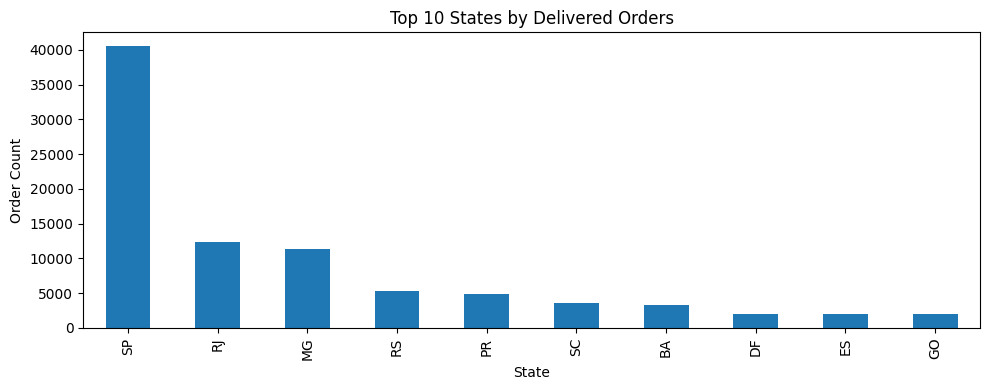

In [15]:
# ---- 4.3 Regional demand: orders by state (top 10) ----
state_orders = (
    df_delivered.drop_duplicates("order_id")
    .groupby("customer_state")["order_id"].count()
    .sort_values(ascending=False)
    .head(10)
)

plt.figure(figsize=(10, 4))
state_orders.plot(kind="bar")
plt.title("Top 10 States by Delivered Orders")
plt.ylabel("Order Count")
plt.xlabel("State")
plt.tight_layout()
plt.show()

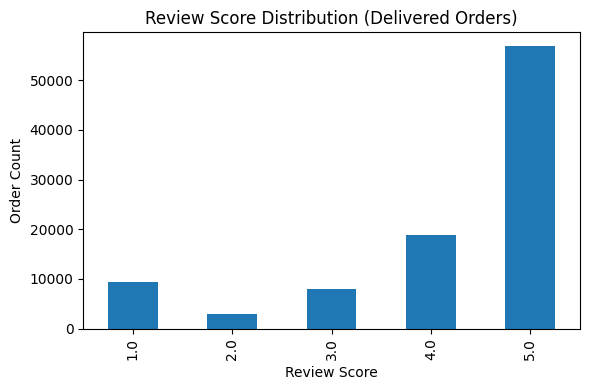

In [16]:
# ---- 4.4 Satisfaction proxy: review score distribution ----
review_dist = df_delivered.drop_duplicates("order_id")["review_score"].value_counts().sort_index()

plt.figure(figsize=(6, 4))
review_dist.plot(kind="bar")
plt.title("Review Score Distribution (Delivered Orders)")
plt.ylabel("Order Count")
plt.xlabel("Review Score")
plt.tight_layout()
plt.show()

In [17]:
# =========================
# 5) Modeling Part A: Product-to-Product Recommendations (Co-occurrence)
# =========================
# Goal: "Customers who bought X also bought Y"
# Approach: Build an order-product matrix (implicit), compute item-item cosine similarity.

# 5.1 Create index mappings
# Use order_id as "basket" (each order is a set of products)
basket = df_delivered[["order_id", "product_id"]].drop_duplicates()

product_ids = basket["product_id"].unique()
prod_to_idx = {p:i for i, p in enumerate(product_ids)}
idx_to_prod = {i:p for p, i in prod_to_idx.items()}

order_ids = basket["order_id"].unique()
order_to_idx = {o:i for i, o in enumerate(order_ids)}

basket keeps only unique (order_id, product_id) pairs, so each order is treated as a shopping basket containing multiple products.
product_ids collects all unique products, and prod_to_idx assigns each product a numeric index
(e.g., P1→0, P2→1, P3→2).

order_ids collects all unique orders, and order_to_idx assigns each order a numeric index
(e.g., O1→0, O2→1).

In [18]:
order_ids.shape

(96478,)

In [19]:
# 5.2 Build sparse order x product matrix
row = basket["order_id"].map(order_to_idx).values
col = basket["product_id"].map(prod_to_idx).values
data = np.ones(len(basket), dtype=np.float32)

X_op = csr_matrix((data, (row, col)), shape=(len(order_ids), len(product_ids)))

This block converts the basket data into a matrix form that the recommendation model can work with.

row maps each order_id to its numeric index, telling which order (row) a product belongs to.

col maps each product_id to its numeric index, telling which product (column) it is.

data is a list of 1s, meaning “this product appears in this order”.

X_op becomes an Order × Product matrix where:

rows = orders

columns = products

value = 1 if the product was part of that order, otherwise 0.

|    | P1 | P2 | P3 | P4 |
| -- | -- | -- | -- | -- |
| O1 | 1  | 1  | 1  | 0  |
| O2 | 1  | 0  | 0  | 1  |


In [20]:
# 5.3 Compute item-item cosine similarity efficiently
# item vectors are columns; compute X^T X after normalizing columns
X_item = X_op.T.tocsr()
X_item_norm = normalize(X_item, axis=1)   # normalize each item vector
item_sim = (X_item_norm @ X_item_norm.T).tocsr()  # item-item cosine similarity

def recommend_similar_products(product_id: str, top_k: int = 10):
    """Return top_k similar products based on co-occurrence cosine similarity."""
    if product_id not in prod_to_idx:
        return []

    i = prod_to_idx[product_id]
    sims = item_sim.getrow(i).toarray().ravel()
    sims[i] = -1  # exclude itself

    top_idx = np.argsort(-sims)[:top_k]
    results = [(idx_to_prod[j], float(sims[j])) for j in top_idx if sims[j] > 0]
    return results


This part computes product-to-product similarity and then uses it to recommend “Customers who bought X also bought Y”.

How the data looks (small example):
If orders are:

O1: P1, P2, P3
O2: P1, P2
O3: P1, P4
Then products co-occur like this: P1 is often with P2, sometimes with P3/P4.

|    | P1   | P2   | P3   | P4   |
| -- | ---- | ---- | ---- | ---- |
| P1 | 1.0  | 0.82 | 0.58 | 0.58 |
| P2 | 0.82 | 1.0  | 0.71 | 0.00 |
| P3 | 0.58 | 0.71 | 1.0  | 0.00 |
| P4 | 0.58 | 0.00 | 0.00 | 1.0  |

[("P2", 0.82), ("P3", 0.58), ("P4", 0.58)]
Meaning: if you input P1, it recommends P2/P3/P4 because they are most frequently co-purchased with P1.

In [21]:
# Example (pick a random product)
example_product = product_ids[2]
print("Example product:", example_product)
print("Similar products:", recommend_similar_products(example_product, top_k=10))

Example product: c777355d18b72b67abbeef9df44fd0fd
Similar products: [('928c2c0fdf465581daac95380af04b3e', 0.3333333134651184)]


In [22]:
item_sim

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 40260 stored elements and shape (32216, 32216)>

In [23]:
# =========================
# 6) Modeling Part B: User-to-Item Recommendations (Implicit CF)
# =========================
# Goal: "Recommend products to a customer based on their past purchases"
# We'll do a simple item-based scoring:
# score(user, item) = sum(sim(item, items_user_bought))

In [24]:
# 6.1 Build user-product interaction matrix
user_buys = df_delivered[["customer_unique_id", "product_id"]].drop_duplicates()

user_ids = user_buys["customer_unique_id"].unique()
user_to_idx = {u:i for i, u in enumerate(user_ids)}
idx_to_user = {i:u for u, i in user_to_idx.items()}

row_u = user_buys["customer_unique_id"].map(user_to_idx).values
col_p = user_buys["product_id"].map(prod_to_idx).values
data_u = np.ones(len(user_buys), dtype=np.float32)

X_up = csr_matrix((data_u, (row_u, col_p)), shape=(len(user_ids), len(product_ids)))

This builds a User × Product matrix that represents purchase history: rows are users, columns are products, and the value is 1 if the user bought that product.

X_up looks like
|    | P1 | P2 | P3 |
| -- | -- | -- | -- |
| U1 | 1  | 1  | 0  |
| U2 | 0  | 1  | 1  |


In [25]:
X_up.shape

(93358, 32216)

In [26]:
def recommend_for_user(customer_unique_id: str, top_k: int = 10):
    """Recommend products to a user using item-item similarity + user's history."""
    if customer_unique_id not in user_to_idx:
        return []

    u = user_to_idx[customer_unique_id]
    user_vec = X_up.getrow(u)  # 1 x num_items
    owned = set(user_vec.indices.tolist())

    # score = user_vec * item_sim  (1xI) * (IxI) => (1xI)
    scores = (user_vec @ item_sim).toarray().ravel()

    # remove already-owned
    for j in owned:
        scores[j] = -1

    top_idx = np.argsort(-scores)[:top_k]
    results = [(idx_to_prod[j], float(scores[j])) for j in top_idx if scores[j] > 0]
    return results

Assume we have 5 products:
P1 = Mobile
P2 = Charger
P3 = Earphones
P4 = Laptop
P5 = Mouse

User purchase history (from X_up)
User U1 has bought: P1 and P3. So the user row vector looks like:
user_vec = [1, 0, 1, 0, 0]
(meaning: bought P1 and P3)

So: owned = {P1, P3}

Product-to-product similarity matrix (item_sim)
|    | P1  | P2  | P3  | P4  | P5  |
| -- | --- | --- | --- | --- | --- |
| P1 | 1.0 | 0.8 | 0.2 | 0.1 | 0.0 |
| P2 | 0.8 | 1.0 | 0.4 | 0.2 | 0.1 |
| P3 | 0.2 | 0.4 | 1.0 | 0.7 | 0.3 |
| P4 | 0.1 | 0.2 | 0.7 | 1.0 | 0.5 |
| P5 | 0.0 | 0.1 | 0.3 | 0.5 | 1.0 |

Score of a product = sum of similarities with the products user already bought
Since U1 bought P1 and P3, each product score is:

Score(P2) = sim(P1,P2) + sim(P3,P2) = 0.8 + 0.4 = 1.2

Score(P4) = sim(P1,P4) + sim(P3,P4) = 0.1 + 0.7 = 0.8

Score(P5) = sim(P1,P5) + sim(P3,P5) = 0.0 + 0.3 = 0.3

So the full scores vector becomes:

[score(P1), score(P2), score(P3), score(P4), score(P5)] = [1.2, 1.2, 1.2, 0.8, 0.3]

(Yes, P1 and P3 also get high scores because they match themselves, but we remove them next.)

Sorting highest first gives: P2 (1.2), P4 (0.8), P5 (0.3)

Because the user bought P1 (Mobile) and P3 (Earphones), the model recommends:
P2 (Charger) as strongest, because it is highly related to both P1 and P3
then P4 (Laptop) and P5 (Mouse) based on weaker similarity

In [27]:
# Example (pick a user with some purchases)
example_user = user_ids[0]
print("\nExample user:", example_user)
print("User recommendations:", recommend_for_user(example_user, top_k=10))


Example user: 871766c5855e863f6eccc05f988b23cb
User recommendations: [('436c8d57ff8d4aa254318e9bd9b48c83', 0.19245009124279022)]


In [28]:
# =========================
# 7) Simple Offline Evaluation (Precision@K) for User Recommendations
# =========================
# We'll do a time-based split per user:
# - Training: earlier purchases
# - Test: last purchased item (or last 20% if enough)
# Evaluate if the held-out item appears in top-K recommendations.
# For each user, can our recommender predict the last item they bought, using only their earlier purchases?”
# If the last item appears in the top K recommendations, we count it as a “hit”.

df_eval = df_delivered[["customer_unique_id", "product_id", "order_purchase_timestamp"]].drop_duplicates()
df_eval = df_eval.sort_values(["customer_unique_id", "order_purchase_timestamp"])


# Keeps only the columns needed for evaluation (user, product, time)
#Removes duplicates
# Sorts purchases for each user in time order

After Sorting
| user | product | time |
| ---- | ------- | ---- |
| U1   | P1      | t1   |
| U1   | P2      | t2   |
| U1   | P3      | t3   |
| U2   | P2      | t1   |
| U2   | P4      | t2   |


In [29]:
# build per-user sequences
user_groups = df_eval.groupby("customer_unique_id")["product_id"].apply(list)

# only users with enough history
eligible_users = user_groups[user_groups.apply(len) >= 5].index.tolist()

This creates something like:

U1 → [P1, P2, P3, P5, P6]
U2 → [P2, P4, P7, P8, P9]
So each user becomes a time-ordered list of products they bought.

We keep users who bought at least 5 products
Reason: if a user has only 1–2 purchases, evaluation is not meaningful

What precision_at_k() returns

Precision@K = hits / total_users_tested
hits: number of users where the last product was correctly in top-K
total: users evaluated

In [30]:
def precision_at_k(k=10, max_users=2000, seed=42):
    rng = np.random.default_rng(seed)
    sample_users = eligible_users
    # If there are too many users, we randomly evaluate only up to max_users so it runs faster.
    if len(sample_users) > max_users:
        sample_users = rng.choice(sample_users, size=max_users, replace=False).tolist()
    

    hits = 0
    total = 0
    # For each user, split into train and test
    # U1 purchases:
    #  [P1, P2, P3, P4, P5] 
    # Then:
    # test_item = P5 (last purchase)
    # train_items = {P1, P2, P3, P4} (everything before it)
    # So we are testing:
    # “Using P1–P4, can we recommend P5 in the top K?”

    for u in sample_users:
        seq = user_groups.loc[u]
        test_item = seq[-1]
        train_items = set(seq[:-1])

        # If user not in our matrix (shouldn't happen) skip
        if u not in user_to_idx:
            continue

        # Temporarily compute scores from train_items only
        # Build a temporary user vector for scoring
        # This creates a 1 × num_products vector like:
        # If user trained on {P1, P3, P4}:
        # | P1 | P2 | P3 | P4 | P5 |
        # | -- | -- | -- | -- | -- |
        # | 1  | 0  | 1  | 1  | 0  |

        train_idx = [prod_to_idx[p] for p in train_items if p in prod_to_idx]
        if not train_idx:
            continue

        # Create sparse 1xI with 1s at train_idx
        temp_user = csr_matrix(
            (np.ones(len(train_idx), dtype=np.float32), ([0]*len(train_idx), train_idx)),
            shape=(1, len(product_ids))
        )

        scores = (temp_user @ item_sim).toarray().ravel()
        for j in train_idx:
            scores[j] = -1

        top_idx = np.argsort(-scores)[:k]
        top_prods = {idx_to_prod[j] for j in top_idx}

        if test_item in top_prods:
            hits += 1
        total += 1

    return hits / total if total else 0.0, total

p10, n = precision_at_k(k=10)
print(f"\nPrecision@10 (sampled users): {p10:.4f} over {n} users")


Precision@10 (sampled users): 0.5147 over 68 users


In [31]:
# =========================
# 8) Modeling Part C (Optional): Use Review Text to Predict Low Satisfaction
# =========================
# Business value: detect "risk" products/orders with low satisfaction.
# We'll train a quick model to predict low rating (<=2) from review text.

In [32]:
#Keeps only delivered rows where both review text and score exist.
text_df = df_delivered.dropna(subset=["review_comment_message", "review_score"]).drop_duplicates("order_id")
text_df = text_df[["review_comment_message", "review_score"]].copy()

#Converts the review score into a binary label:
#score 1 or 2 → low_rating = 1 (bad review)
#score 3, 4, 5 → low_rating = 0 (not bad)
text_df["low_rating"] = (text_df["review_score"] <= 2).astype(int)


# keep reasonable text length
#Ensures text is a string and removes extra spaces.
# Removes very short messages (like “ok”, “good”) because they don’t contain enough signal.
text_df["review_comment_message"] = text_df["review_comment_message"].astype(str).str.strip()
text_df = text_df[text_df["review_comment_message"].str.len() >= 10]

# Train/test split (simple)
from sklearn.model_selection import train_test_split
# stratify ensures both sets have similar proportions of low vs non-low ratings (important when classes are imbalanced).
train_text, test_text = train_test_split(text_df, test_size=0.2, random_state=42, stratify=text_df["low_rating"])


#TF-IDF converts each review into a vector of word features.
# ngram_range=(1,2) means it uses:
# single words (“late”)
# two-word phrases (“delivery late”, “not good”)
# fit_transform learns vocabulary from training data and builds training vectors.
# transform uses the same vocabulary to build test vectors.

tfidf = TfidfVectorizer(max_features=20000, ngram_range=(1,2))
X_train = tfidf.fit_transform(train_text["review_comment_message"])
X_test = tfidf.transform(test_text["review_comment_message"])

clf = LogisticRegression(max_iter=2000)
clf.fit(X_train, train_text["low_rating"])

pred = clf.predict(X_test)
print("\nLow-rating text classifier report:")
print(classification_report(test_text["low_rating"], pred))


Low-rating text classifier report:
              precision    recall  f1-score   support

           0       0.92      0.93      0.93      5333
           1       0.80      0.77      0.79      1831

    accuracy                           0.89      7164
   macro avg       0.86      0.85      0.86      7164
weighted avg       0.89      0.89      0.89      7164



#### Train a Random Forest classifier

In [33]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,        # number of trees
    max_depth=20,            # limit depth to avoid overfitting
    min_samples_leaf=5,      # minimum samples per leaf
    random_state=42,
    n_jobs=-1                # use all CPU cores
)

rf.fit(X_train, train_text["low_rating"])


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",20
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",5
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(y

In [34]:
# Predict on test data
rf_pred = rf.predict(X_test)


In [35]:
from sklearn.metrics import classification_report

print("Random Forest – Low Rating Prediction")
print(classification_report(test_text["low_rating"], rf_pred))

#precision → how accurate “low-rating” predictions are

# recall → how many actual low ratings you caught

#f1-score → balance of both

Random Forest – Low Rating Prediction
              precision    recall  f1-score   support

           0       0.78      0.99      0.87      5333
           1       0.86      0.19      0.31      1831

    accuracy                           0.78      7164
   macro avg       0.82      0.59      0.59      7164
weighted avg       0.80      0.78      0.73      7164



### XGBOOST

In [36]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report


In [37]:
xgb = XGBClassifier(
    objective="binary:logistic",   # binary classification
    n_estimators=300,              # number of trees
    max_depth=6,                   # keep trees shallow (VERY important)
    learning_rate=0.1,             # step size
    subsample=0.8,                 # row sampling
    colsample_bytree=0.8,           # feature sampling
    reg_alpha=1.0,                 # L1 regularization
    reg_lambda=1.0,                # L2 regularization
    n_jobs=-1,
    random_state=42,
    eval_metric="logloss"
)


In [38]:
xgb.fit(X_train, train_text["low_rating"])


,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes f

In [39]:
xgb_pred = xgb.predict(X_test)


In [40]:
print("XGBoost – Low Rating Prediction")
print(classification_report(test_text["low_rating"], xgb_pred))


XGBoost – Low Rating Prediction
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      5333
           1       0.77      0.77      0.77      1831

    accuracy                           0.88      7164
   macro avg       0.85      0.85      0.85      7164
weighted avg       0.88      0.88      0.88      7164



#### Why not a single Decision Tree
Problem with TF-IDF text data

TF-IDF has thousands of sparse features (10k+)

Most values are 0

Decision trees:

overfit very easily

become very deep

memorize rare word patterns

Result

Very high training accuracy

Poor test/generalization performan

#### Why not XGBoost (by default) for TF-IDF
XGBoost is best for:

Dense, structured features

Numerical interactions

Tabular datasets (fraud, credit risk, churn)

TF-IDF + XGBoost issues

##### TF-IDF is:

extremely sparse

very high dimensional

##### XGBoost:

trains slower

needs careful tuning

uses much more memory

often gives little gain over Logistic Regression

##### In many real NLP tasks:

Logistic Regression ≈ XGBoost, but LR is 10× faster and simpler.

#### Why Random Forest is better than a Decision Tree
Random Forest fixes the tree’s weaknesses:

Uses many trees

Each tree sees:

a subset of features

a subset of data

Final prediction = majority vote

Why it works better

Reduces overfitting

Handles noisy word features better

Still interpretable at a high level

Still a limitation

Slower than linear models

Memory heavy for very large vocabularie